In [ ]:
#Importing packages
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pywt
import math

In [ ]:
# pixel average fusion
def pixel_avg(image1,image2):
  # Simple averaging fusion
  fused_image = cv2.addWeighted(image1, 0.5, image2, 0.5, 0)
  return fused_image

# laplacian pyramid fusion
def laplacian_pyramid_fusion(image1, image2):
    #Generate Gaussian pyramids for both images
    levels=6
    gaussian_pyramid1 = [image1.astype(np.float32)]
    gaussian_pyramid2 = [image2.astype(np.float32)]
    for i in range(levels - 1):
        image1 = cv2.pyrDown(image1)
        image2 = cv2.pyrDown(image2)
        gaussian_pyramid1.append(image1.astype(np.float32))
        gaussian_pyramid2.append(image2.astype(np.float32))

    # Generate Laplacian pyramids
    laplacian_pyramid1 = [gaussian_pyramid1[levels - 1]]
    laplacian_pyramid2 = [gaussian_pyramid2[levels - 1]]
    for i in range(levels - 1, 0, -1):
        expanded1 = cv2.pyrUp(gaussian_pyramid1[i])
        expanded2 = cv2.pyrUp(gaussian_pyramid2[i])
        laplacian1 = cv2.subtract(gaussian_pyramid1[i - 1], expanded1[:gaussian_pyramid1[i - 1].shape[0], :gaussian_pyramid1[i - 1].shape[1]])
        laplacian2 = cv2.subtract(gaussian_pyramid2[i - 1], expanded2[:gaussian_pyramid2[i - 1].shape[0], :gaussian_pyramid2[i - 1].shape[1]])
        laplacian_pyramid1.append(laplacian1)
        laplacian_pyramid2.append(laplacian2)

    # Combine the Laplacian pyramids
    blended_pyramid = []
    for lap1, lap2 in zip(laplacian_pyramid1, laplacian_pyramid2):
        blended_pyramid.append((lap1 + lap2)/2)

    # Reconstruct the fused image from the blended pyramid
    fused_image = blended_pyramid[0]
    for i in range(1, levels):
        fused_image = cv2.pyrUp(fused_image)
        fused_image = cv2.add(fused_image[:blended_pyramid[i].shape[0], :blended_pyramid[i].shape[1]], blended_pyramid[i])

    return fused_image.astype(np.uint8)

# pca fusion
def pca_fusion(image1, image2):
    # Reshape images into 2D arrays
    data1 = image1.reshape(-1, 3)
    data2 = image2.reshape(-1, 3)

    # Perform PCA on the image data
    mean1 = np.mean(data1, axis=0)
    mean2 = np.mean(data2, axis=0)
    centered_data1 = data1 - mean1
    centered_data2 = data2 - mean2

    cov1 = np.cov(centered_data1, rowvar=False)
    cov2 = np.cov(centered_data2, rowvar=False)

    _, eigvec1 = np.linalg.eigh(cov1)
    _, eigvec2 = np.linalg.eigh(cov2)

    # Combine the principal components
    combined_eigvec = 0.5 * (eigvec1 + eigvec2)

    # Generate the fused image using the combined components
    fused_data = np.dot(centered_data1, combined_eigvec.T) + mean1
    fused_image = np.clip(fused_data, 0, 255).astype(np.uint8).reshape(image1.shape)

    return fused_image

# feature level fusion
def feature_level_fusion(image1,image2):
  edges1 = cv2.Canny(image1, 100, 200)
  edges2 = cv2.Canny(image2, 100, 200)

# Combine the edges from both images
  fused_edges = np.maximum(edges1, edges2)

# Create a blank image for the fused result
  fused_image = np.zeros_like(image1)

# Use the fused edges as a mask to combine pixel values from both images
  fused_image[fused_edges != 0] = image2[fused_edges != 0]
  fused_image[fused_edges == 0] = image1[fused_edges == 0]
  return fused_image

#region wise fusion
def region_fusion(image1,image2):
  num_rows, num_cols = 4, 4
  rows1, cols1, _ = image1.shape
  region_height, region_width = rows1 // num_rows, cols1 // num_cols

# Initialize an empty canvas for the fused image
  fused_image = np.zeros_like(image1)

# Iterate through each region and perform region-based fusion (averaging)
  for i in range(num_rows):
      for j in range(num_cols):
        # Define the region boundaries
          row_start, row_end = i * region_height, (i + 1) * region_height
          col_start, col_end = j * region_width, (j + 1) * region_width

        # Extract regions from both images
          region1 = image1[row_start:row_end, col_start:col_end]
          region2 = image2[row_start:row_end, col_start:col_end]

        # Average the pixel values in the regions
          fused_region = cv2.addWeighted(region1, 0.5, region2, 0.5, 0)

        # Place the fused region into the fused image canvas
          fused_image[row_start:row_end, col_start:col_end] = fused_region
  return fused_image

#guided filter fusion
def guided_filter_fusion(input1, input2):
    radius=5
    eps=0.1
    guidance=input1.copy()
    guidance = guidance.astype(np.float32) / 255.0
    input1 = input1.astype(np.float32) / 255.0
    input2 = input2.astype(np.float32) / 255.0

    # Compute the guided filter for both inputs with the guidance image
    guided_filter1 = cv2.ximgproc.guidedFilter(guidance, input1, radius, eps)
    guided_filter2 = cv2.ximgproc.guidedFilter(guidance, input2, radius, eps)

    # Combine the guided filters to create the fused image
    fused_image = (guided_filter1 + guided_filter2) / 2.0

    # Normalize the fused image to the range [0, 255]
    fused_image = (fused_image * 255).astype(np.uint8)

    return fused_image

# intensity hus saturation fusion
def ihs_fusion(image1, image2):
    # Convert images to the HSV color space
    image1_hsv = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
    image2_hsv = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)

    # Split images into Hue, Saturation, and Intensity channels
    h1, s1, v1 = cv2.split(image1_hsv)
    h2, s2, v2 = cv2.split(image2_hsv)

    # Fuse the Intensity components using the maximum value
    fused_intensity = np.maximum(v1, v2)

    # Merge the fused Intensity with the original Hue and Saturation components
    fused_hsv = cv2.merge((h1, s1, fused_intensity))

    # Convert the fused image back to BGR color space
    fused_image = cv2.cvtColor(fused_hsv, cv2.COLOR_HSV2BGR)

    return fused_image

#discrete cosine transform fusion
def dct_color_fusion(image1, image2):
    # Apply DCT to each channel separately
    dct_channels1 = [cv2.dct(np.float32(image1[:, :, i])) for i in range(3)]
    dct_channels2 = [cv2.dct(np.float32(image2[:, :, i])) for i in range(3)]

    # Perform fusion by averaging the DCT coefficients for each channel
    fused_dct_channels = [(dct1 + dct2) / 2 for dct1, dct2 in zip(dct_channels1, dct_channels2)]

    # Reconstruct the fused image from the fused DCT coefficients
    fused_image = np.zeros_like(image1)
    for i in range(3):
        fused_image[:, :, i] = cv2.idct(fused_dct_channels[i])

    return fused_image.astype(np.uint8)

#select better pixel fusion
def select_better_pixel(image1, image2):
    better_image = np.zeros_like(image1)

    # Iterate through each pixel
    for i in range(image1.shape[0]):
        for j in range(image1.shape[1]):
            # Compare pixel values and choose the better one
            if np.mean(image1[i, j]) > np.mean(image2[i, j]):
                better_image[i, j] = image1[i, j]
            else:
                better_image[i, j] = image2[i, j]

    return better_image

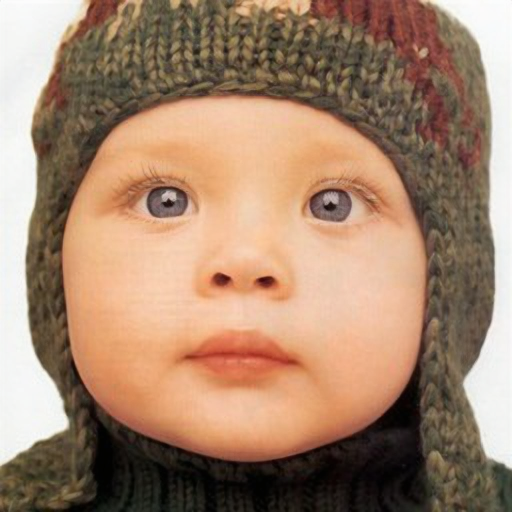

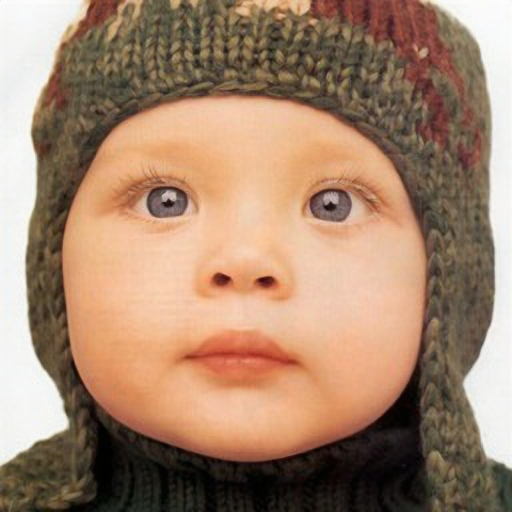

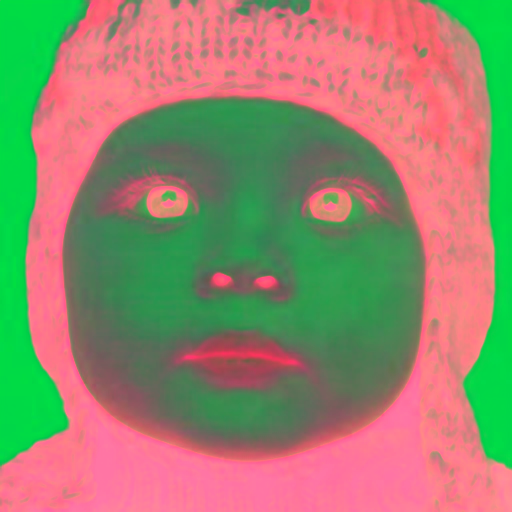

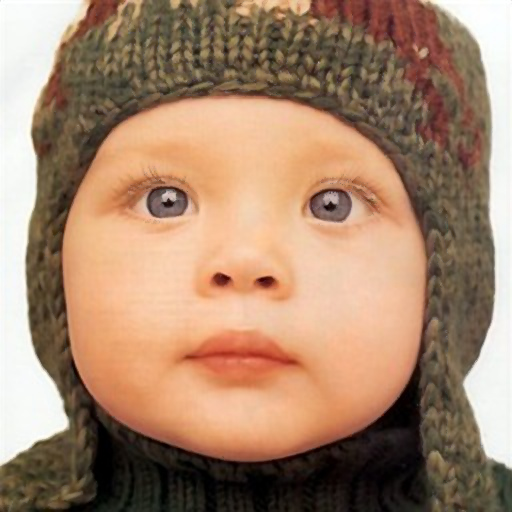

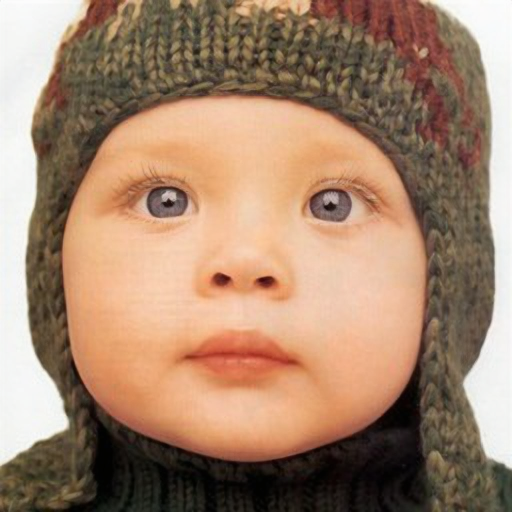

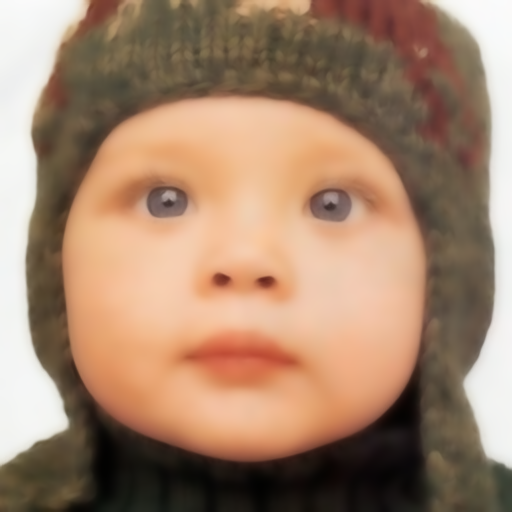

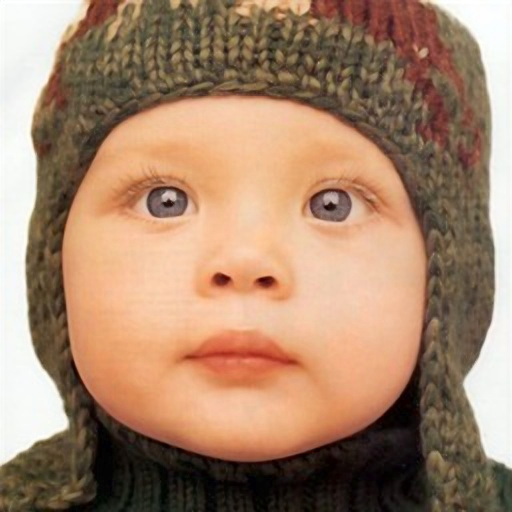

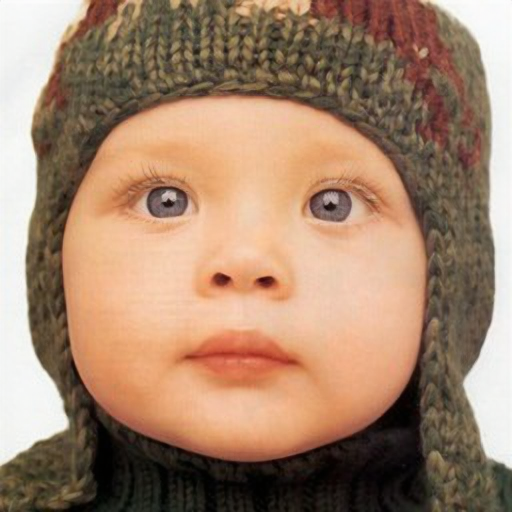

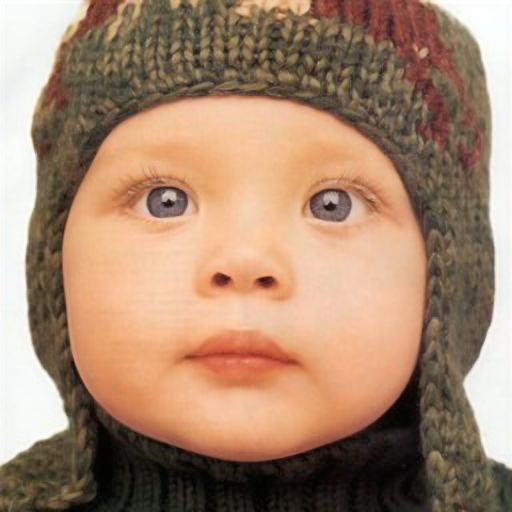

In [ ]:
image1=cv2.imread("srcnn.jpeg")
image2=cv2.imread("gan.png")
image3=cv2.imread("ref.png")
image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
pix_avg=pixel_avg(image1,image2)#pixel avg fusion
cv2_imshow(pix_avg)
lpf=laplacian_pyramid_fusion(image1,image2)#lap pyr fusion
cv2_imshow(lpf)
pca=pca_fusion(image1,image2)#pca fusion
cv2_imshow(pca)
flf=feature_level_fusion(image1,image2)#feature level fusion
cv2_imshow(flf)
regf=region_fusion(image1,image2)#region wise fusion
cv2_imshow(regf)
gff=guided_filter_fusion(image1,image2)#guided filter
cv2_imshow(gff)
ihs=ihs_fusion(image1,image2)#ihs fusion
cv2_imshow(ihs)
dct=dct_color_fusion(image1,image2)#discrete cosine fusion
cv2_imshow(dct)
sbp=select_better_pixel(image1,image2)#select better pixel
cv2_imshow(sbp)
techs=[pix_avg,lpf,pca,flf,regf,gff,ihs,dct,sbp]

In [ ]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):

    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])

    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))

    return scores


print("Fused Images :")
print(compare_images(pix_avg,image3))
print(compare_images(lpf,image3))
print(compare_images(pca,image3))
print(compare_images(flf,image3))
print(compare_images(regf,image3))
print(compare_images(gff,image3))
print(compare_images(ihs,image3))
print(compare_images(dct,image3))
print(compare_images(sbp,image3))
print("GAN AND SRCNN :")
print(compare_images(image2,image3))
print(compare_images(image1,image3))



Fused Images :


<ipython-input-21-99897b4d138f>:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target, ref, multichannel =True))


[32.857360506576384, 101.03353881835938, 0.9060577328928776]
[32.784364088100176, 102.74606704711914, 0.9069035544017893]
[6.676950719607298, 41928.23140716553, 0.27060483710462374]
[32.81634968971281, 101.99212646484375, 0.9006505774484342]
[32.857360506576384, 101.03353881835938, 0.9060577328928776]
[27.19837930438252, 371.8464889526367, 0.7292754756555876]
[33.06135212892044, 96.39764022827148, 0.9004811993869163]
[32.65585376184972, 105.83181381225586, 0.906671161354805]
[32.68071194222642, 105.227783203125, 0.8953283290320786]
GAN AND SRCNN :
[31.23895346297525, 146.65817260742188, 0.8912539956870563]
[32.98264602425939, 98.16055679321289, 0.9017984765743162]
